In [2]:
import numpy as np
np.random.seed(1337)
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import random
import urllib, json
import re
from datetime import datetime
import requests


Using TensorFlow backend.


In [3]:
memory = deque(maxlen=2000)
gamma = 0.95  
epsilon = 0.05  # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.99
learning_rate = 0.001
batch_size = 5
memory = []
action_hist = []
class Account:
    cash = 100000
    amount_held = 0
    def calc_value(self,current_price):
        return self.amount_held * current_price
account = Account()

In [4]:
def build_network(input_sz):
    model = Sequential()
    model.add(Dense(125,input_dim=input_sz, activation='relu'))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(2, activation='linear'))
    try:
        model.load_weights("rltrader.h5")
        print "LOADEd weights"
    except:
        pass
    model.compile(loss='mse',optimizer=Adam(lr=learning_rate)) 
    return model

In [5]:
def get_data(symbol):
    q = deque(maxlen=3)
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&outputsize=full&symbol="+symbol+"&apikey=TOGGSCK5JLEEJTGL"
    url_rsi = "https://www.alphavantage.co/query?function=RSI&symbol="+symbol+"&interval=daily&time_period=10&series_type=close&apikey=TOGGSCK5JLEEJTGL"
    url_sma = "https://www.alphavantage.co/query?function=SMA&symbol="+symbol+"&interval=daily&time_period=10&series_type=close&apikey=TOGGSCK5JLEEJTGL"
    url_cci = "https://www.alphavantage.co/query?function=CCI&symbol="+symbol+"&interval=daily&time_period=10&series_type=close&apikey=TOGGSCK5JLEEJTGL"
    
    response_prices = requests.get(url)
    response_rsi = requests.get(url_rsi)
    response_sma = requests.get(url_sma)
    response_cci = requests.get(url_cci)
    
    data = response_prices.json()
    data_rsi = response_rsi.json()
    data_sma = response_sma.json()
    data_cci = response_cci.json()
    
    
    data = data["Time Series (Daily)"]
#     print(data_rsi)
    data_rsi = data_rsi["Technical Analysis: RSI"]
    data_sma = data_sma["Technical Analysis: SMA"]
    data_cci = data_cci["Technical Analysis: CCI"]
    
    ds = {}
    ds["date"] = []
    ds["close"] = []
    ds["trend"] = []
#     ds["open"] = []
#     ds["volume"] = []
#     ds["high"] = []
#     ds["low"] = []
    ds["rsi"] = []
    ds["sma"] = []
    ds["cci"] = []
    
#     i = 0
    q.append(1)
    for time_point in data:
        try:
            ds["date"] += [time_point]
            ds["close"] += [float(data[time_point]["4. close"])]
            ds["trend"] += [(float(data[time_point]["4. close"])-(sum(list(q))/len(list(q))))/(sum(list(q))/len(list(q)))]
            last_close = float(data[time_point]["4. close"])
            if last_close <= 0:
                q.append(1)
            else:
                q.append(last_close)
#             ds["open"] += [float(data[time_point]["1. open"])]
#             ds["volume"] += [float(data[time_point]["5. volume"])]
#             ds["high"] += [float(data[time_point]["2. high"])]
#             ds["low"] += [float(data[time_point][ "3. low"])]
        except KeyError as e:
            continue
        try:
            ds["rsi"] += [float(data_rsi[time_point]["RSI"])]
        except KeyError as e:
            ds["rsi"] += [sum(ds["rsi"])/len(ds["rsi"])]
        try:
            ds["sma"] += [float(data_sma[time_point]["SMA"])]
        except KeyError as e:
            ds["sma"] += [sum(ds["sma"])/len(ds["sma"])]
        try:
            ds["cci"] += [float(data_cci[time_point]["CCI"])]
        except KeyError as e:
            ds["cci"] += [sum(ds["cci"])/len(ds["cci"])]
    
    df=pd.DataFrame(ds)
    df = df.sort_values(by='date')
    df = df.reset_index(drop=True)
    return df
        


In [6]:
def remember(s,a,r,sp):
    memory.append((s,a,r,sp))

In [7]:
def update(memory):
#     Take random sample from memory
    batch = random.sample(memory, batch_size) 
#     Train network on batch
    for s, a, r, sp in batch:
#       if state is final there is no future rewards
        target = r
#       discounted future rewards
    
        target = r + gamma * \
           np.amax(model.predict(sp)[0])
                
#       Get pred then replace action with our target
        target_f = model.predict(s)
        target_f[0][a] = target
        model.fit(s, target_f, epochs=1, verbose=0)

In [15]:
def get_act(obs):
    if obs[1]["rsi"] < 30:
        return 1
    if obs[1]["rsi"] > 70:
        return 0
    else:
        return 3
  

In [9]:
int(random.uniform(0, 2))

0

In [20]:

def act(act,day):
    if act == 3:
        return 0
    current_val = account.calc_value(day[1]["close"])
    i = day[0]
    future = df.close.iloc[i:i+3].mean()
    if act == 1:
        buy["buy"] += [day[1]["close"]]
        buy["date"] += [df_d.date.iloc[day[0]]]
        if (account.cash - (day[1]["close"]*20)) >= 0:
            account.amount_held =  account.amount_held + 20
            account.cash = account.cash - (20*day[1]["close"])
        if ((future - day[1]["close"])/day[1]["close"]) > 0:
            return 1
        else:
            return -1
#             if (account.calc_value(future) - current_val) > 0:
#                 return 1
#             else:
#                 return -1
    #         Buy some shares reward is if we make money in a week
    else:
        
        sell["sell"] += [day[1]["close"]]
        sell["date"] += [df_d.date.iloc[day[0]]]
        to_sell =int((random.random()*account.amount_held))
        if account.amount_held > 0:
            account.cash = account.cash + (to_sell*day[1]["close"])
            account.amount_held = account.amount_held -to_sell
        if -((future - day[1]["close"])/day[1]["close"]) > 0:
            return 1
        else:
            return -1
#         if (account.calc_value(future) - current_val) < 0:
#             return 1
#         else:
#             return -1
    
    return -0.05
#         Sell some shares reward is if we avoid losing money in a week

In [11]:

#     print d[1]["date"]


In [12]:
range(0,1)

[0]

In [21]:
# model = build_network(len(df.columns))
# prv_obs = None
feats = ["trend","rsi","sma","cci"]
buy = {}
buy["buy"] = []
buy["date"] = []
sell = {}
sell["sell"] = []
sell["date"] = []
worth = {}
worth["worth"]=[]
gl = []
epochs = 1
df_d = None
codes = ["ASX:RBL","TSLA","MSFT","MU","ASX:ANZ","NVDA"]
for epoch in range(0,epochs):
    buy = {}
    buy["buy"] = []
    buy["date"] = []
    sell = {}
    sell["sell"] = []
    sell["date"] = []
    worth = {}
    worth["worth"]=[]
    gl = []
    i = 0
    memory = deque(maxlen=2000)
    account = Account()
    df = get_data("NVDA")
    df_d = df[["date","close"]]
    del df["date"]
    model = build_network(len(df[feats].columns))
    prv_obs = None

    for day in df.iterrows():
        i = 1 + i
    #     print i
        if i == len(df) - 11:
            print("Episode finished after {} timesteps".format(i+1))
            break
        obs = day[1]
        obs_values = np.reshape(obs[feats].values,[1,len(df[feats].columns)])
        action = get_act(day)
        if action == 1:
            action_hist += ["buy"] 
        else:
            action_hist += ["sell"]
        if i % 100 == 0:
            if action == 1:
                print "Buying" 
            else:
                print "Selling"
            print "day" , i
            print "cash",account.cash
            print "shares held",account.amount_held
            print "net worth",account.calc_value(day[1]["close"]) + account.cash
        worth["worth"] += [account.calc_value(day[1]["close"]) + account.cash]
    #     print(action)
        reward = act(action,day)
    #     print reward
        gl += [(account.calc_value(day[1]["close"]) + account.cash) - 100000]
#         if prv_obs is not None and reward is not None:
#             remember(prv_obs,action,reward,obs_values)
        prv_obs = obs_values  
    #     if done:
    #         model.save_weights("model.h5")
    #         print("Episode finished after {} timesteps".format(t+1))
    #         break
        if len(memory) >= batch_size:
            update(memory)
    print ((sum(gl)/len(gl))/100000)*100

LOADEd weights
Buying
day 100
cash 96647.97
shares held 299
net worth 128491.47
Buying
day 200
cash 135054.82
shares held 296
net worth 153889.3
Buying
day 300
cash 104493.72
shares held 1093
net worth 157230.97
Buying
day 400
cash 30453.19
shares held 2031
net worth 208937.47
Buying
day 500
cash 121179.21
shares held 172
net worth 132686.01
Buying
day 600
cash 20451.61
shares held 2172
net worth 96536.77
Buying
day 700
cash 27.2099999999
shares held 3012
net worth 26081.01
Buying
day 800
cash 42336.21
shares held 204
net worth 44900.49
Buying
day 900
cash 28934.91
shares held 781
net worth 44914.17
Buying
day 1000
cash 38916.05
shares held 541
net worth 50709.85
Buying
day 1100
cash 38945.985
shares held 635
net worth 52573.085
Buying
day 1200
cash 20231.051
shares held 2063
net worth 49773.211
Buying
day 1300
cash 57934.041
shares held 68
net worth 59827.841
Buying
day 1400
cash 41869.991
shares held 721
net worth 61531.661
Buying
day 1500
cash 56183.451
shares held 323
net worth 678

In [22]:
print ((sum(gl)/len(gl))/100000)*100
# df_d
print (133605.115/100000)*100
# print action_hist

-32.4044870047
133.605115


In [23]:
df_buys = pd.DataFrame(buy)
df_sells = pd.DataFrame(sell)
df_worth = pd.DataFrame(worth)

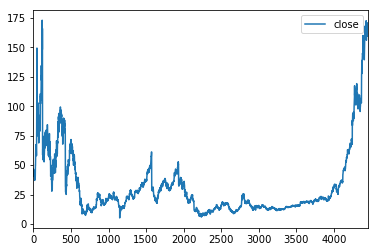

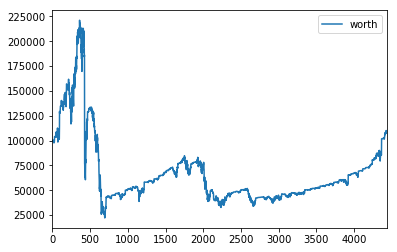

In [24]:
df_d.plot()
df_worth.plot()


In [ ]:
df_buys.plot(style=".")

In [ ]:
# df_d.plot()
df_sells.plot(style=".")

In [ ]:
df_d.date = pd.to_datetime(df_d.date,format='%Y-%m-%d')
df_d = df_d.set_index("date")
df_buys.date = pd.to_datetime(df_buys.date,format='%Y-%m-%d')
df_buys = df_buys.set_index("date")
df_sells.date = pd.to_datetime(df_sells.date,format='%Y-%m-%d')
df_sells = df_sells.set_index("date")
ax = df_d.plot()

ax = df_d.plot()
ax = df_buys.plot(ax=ax)
df_sells.plot(ax=ax)
# # df_sells.groupby(df_sells["date"])
plt.show()

In [ ]:
fig = plt.figure(figsize = (50,50))
ax = fig.gca()
df.rsi.plot(ax=ax)

In [ ]:
fig = plt.figure(figsize = (50,50))
ax = fig.gca()
ax = df_d.plot(ax=ax)
ax = df_buys.plot(style=".",ax=ax)
df_sells.plot(style=".",ax=ax)
# # df_sells.groupby(df_sells["date"])
plt.show()

In [ ]:
df_d

In [ ]:
%%bash
which python